### UPRM Hackathon 2025 - MultiLabel Image Classification using Convolutional Neural Networks

* <b> Author: </b> Jean Han, Hamzah Abdulrazzaq, Edgar Perez
* <b> Date: </b> September 5th, 2025
* <b> Objective: 
UPRM Hackathon 2025 will be focused on exploring the capabilities of Convolutional Neural Networks (CNNs) in tackling complex image classification tasks. Specifically, participants will delve into the realm of MultiLabel, MultiClass image classification using the 'Nasa Geographical Objects' dataset, which comprises a diverse range of geographical features. The dataset includes images of various landscapes, such as islands, mountains, deserts, rivers, lakes, forests, and cities, with some images featuring combinations of these features. The task at hand is to design and optimize CNN architectures to accurately predict the relevant geographical labels for a given image., The challenge lies in developing a robust model that can effectively handle the complexities of MultiLabel, MultiClass classification, requiring meticulous attention to data preprocessing, hyper-parameter tuning, and potentially incorporating techniques such as transfer learning, data augmentation, and ensemble methods. The winning submissions will be evaluated based on their performance, with a key metric being the model's ability to balance precision and recall across multiple labels.
   </b> 
* <b> Dataset License Acknowledgement: Image courtesy of the Earth Science and Remote Sensing Unit, NASA Johnson Space Center


## Table of Contents

- [Background Information: Neural Networks and Multi-Label Classification](#Background-Information:-Neural-Networks-and-Multi-Label-Classification)
- [Importing Necessary Libraries](#Importing-Necessary-Libraries)
- [Configurations + Basic Visualization](#Configurations-+-Basic-Visualization)
- [Dealing with Data Imbalance](#Data-Imbalance)
- [Custom Image Dataset](#Custom-Image-Dataset)
- [Image Augmentation](#Image-Augmentation)
- [Building CNN Architecture](#Building-CNN-Architecture)
- [Model Training](#Model-Training)
- [Visualize Loss and F1](#Visualize-Metrics)
- [Performance Analysis (Where is the model underperforming?)](#Where-is-the-model-underperforming)
- [Performance Analysis (Confusion Matrix)](#Confusion-Matrix)

<!-- ## Background Information: Neural Networks and Multi-Label Classification -->

#### Convolutional Neural Networks:
A convolutional neural network (CNN or ConvNet) is a class of deep neural networks, most commonly applied to analyzing visual imagery. They have proven to be very effective in image and video recognition, recommender systems, image classification, medical image analysis, natural language processing, brain-computer interfaces, and financial time series modeling. CNNs are regularized versions of multilayer perceptrons. Multilayer perceptrons usually mean fully connected networks, that is, each neuron in one layer is connected to all neurons in the next layer. The "fully-connectedness" of these networks makes them prone to overfitting data. Typical ways of regularization include adding some form of magnitude measurement of weights to the loss function. CNNs take a different approach towards regularization: they take advantage of the hierarchical pattern in data and assemble more complex patterns using smaller and simpler patterns. Therefore, on the scale of connectedness and complexity, CNNs are on the lower extreme.Convolutional networks were inspired by biological processes in that the connectivity pattern between neurons resembles the organization of the animal visual cortex. Individual cortical neurons respond to stimuli only in a restricted region of the visual field known as the receptive field. The receptive fields of different neurons partially overlap such that they cover the entire visual field.


#### MultiLabel Classification

In traditional image classification (single-label), each image belongs to exactly one class. However, in multi-label classification, each image can simultaneously belong to multiple classes. For example, an image might contain both a "dog" and a "person" - requiring the model to predict multiple correct labels. This fundamentally changes the classification problem from selecting a single class from mutually exclusive options to making independent binary decisions about the presence of each possible class.

#### Challenges of MultiLabel Classification

1. __Class Imbalance__: Some labels may appear much more frequently than others.
2. __Label Correlations__: Labels often exhibit strong correlations (e.g., "beach" and "ocean" frequently co-occur), which the model needs to learn.
3. __Evaluation Complexity__: Simple accuracy metrics become insufficient; metrics like F1-score, Hamming loss, mean average precision (mAP), or precision-recall curves are more appropriate.
4. __Data Augmentation__: It is critical to ensure diversity of images with Multi-Label tasks. Effective strategies include random crops, flips, rotations, etc. 

#### Helpful Resources:
- [What are Convolutional Neural Networks](https://www.bing.com/videos/search?q=convolutional+neural+network&docid=603549927117705930&mid=E7ED04059A9474B24BFEE7ED04059A9474B24BFE&view=detail&FORM=VIRE)
- [Overview of MultiLabel Classification](https://en.wikipedia.org/wiki/Multi-label_classification)
- [MultiLabel Classification Demo for Beginners](https://medium.com/data-science-in-your-pocket/multi-label-classification-for-beginners-with-codes-6b098cc76f99)
- [Interactive Demo for Image kernels](https://deeplizard.com/resource/pavq7noze2)
- [Introduction to Pooling Layers](https://www.geeksforgeeks.org/deep-learning/cnn-introduction-to-pooling-layer/)

# Download data

In [1]:
!pip install -r requirements.txt

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("olebro/nasa-geographical-objects-multilabel-dataset")

# Importing Necessary Libraries

# Importing Necessary Libraries

In [3]:
import torch   
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sns
import ast
from collections import Counter
from tqdm import tqdm
from torchvision.transforms import transforms
from sklearn.utils import resample
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR
import torchvision.models as models
from collections import namedtuple

In [4]:
import warnings 
warnings.filterwarnings("ignore")

In [5]:
# Threshold Optimization for Multi-Label Classification
def find_optimal_threshold(model, valid_dataloader, thresholds=np.arange(0.1, 0.9, 0.05)):
    """
    Find optimal threshold for multi-label classification
    """
    model.eval()
    best_threshold = 0.5
    best_f1 = 0.0
    
    threshold_results = []
    
    with torch.no_grad():
        # Collect all predictions and true labels
        all_preds = []
        all_labels = []
        
        for x, y in tqdm(valid_dataloader, desc="Collecting predictions"):
            x, y = x.to(Config.device), y.to(Config.device)
            pred = model(x)
            pred_sigmoid = torch.sigmoid(pred)
            
            all_preds.append(to_numpy(pred_sigmoid))
            all_labels.append(to_numpy(y))
        
        all_preds = np.vstack(all_preds)
        all_labels = np.vstack(all_labels)
        
        # Test different thresholds
        for threshold in thresholds:
            pred_binary = (all_preds > threshold).astype(int)
            f1 = f1_score(all_labels, pred_binary, average='micro', zero_division=0)
            threshold_results.append((threshold, f1))
            
            if f1 > best_f1:
                best_f1 = f1
                best_threshold = threshold
                
            print(f"Threshold: {threshold:.2f}, F1: {f1:.4f}")
    
    print(f"\nOptimal threshold: {best_threshold:.2f} with F1: {best_f1:.4f}")
    
    # Plot threshold vs F1 score
    thresholds_list, f1_scores = zip(*threshold_results)
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds_list, f1_scores, 'b-o')
    plt.axvline(x=best_threshold, color='r', linestyle='--', label=f'Best: {best_threshold:.2f}')
    plt.xlabel('Threshold')
    plt.ylabel('F1 Score')
    plt.title('Threshold Optimization for Multi-Label Classification')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return best_threshold, best_f1

In [6]:
train_data_raw = pd.read_csv('data/train.csv')
val_data_raw = pd.read_csv('data/val.csv')

print(f'Training data shape: {train_data_raw.shape}')
print(f'Validation data shape: {val_data_raw.shape}')

Training data shape: (1248, 3)
Validation data shape: (765, 3)


# Configurations + Basic Visualization

In [7]:
class Config:
    # Increased resolution for better feature extraction
    img_dimensions = (224, 224)  # Standard ImageNet size for better pretrained model performance
    channels = 3
    images_path = os.path.join(path, 'images')
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Optimized training hyperparameters
    initial_learning_rate = 0.001  # Higher initial LR with scheduler
    batch_size = 16  # Reduced for higher resolution images
    num_epochs = 50  # More epochs for better convergence
    weight_decay = 1e-4
    
    # Threshold optimization
    threshold = 0.4  # Optimized threshold for multi-label
    
    # Early stopping parameters
    patience = 7
    min_delta = 0.001
    
    print(f"Using device: {device}")
    print(f"Image dimensions: {img_dimensions}")
    print(f"Batch size: {batch_size}")

Using device: cuda
Image dimensions: (224, 224)
Batch size: 16


## Class Imbalance Analysis and Visualization

In [8]:
def analyze_label_distribution(data, label_col='Label Vector', string_col='Label String'):
    """
    Comprehensive analysis of label distribution in multi-label dataset
    """
    # Parse label vectors
    label_vectors = []
    for label_str in data[label_col]:
        label_vec = ast.literal_eval(label_str)
        label_vectors.append(label_vec)
    
    label_vectors = np.array(label_vectors)
    
    # Get unique label combinations and their counts
    unique_combinations = {}
    for i, row in data.iterrows():
        label_combo = row[string_col]
        if label_combo in unique_combinations:
            unique_combinations[label_combo] += 1
        else:
            unique_combinations[label_combo] = 1
    
    # Individual label frequencies
    individual_labels = ['BEACH', 'CITY', 'COAST', 'DESERT', 'FOREST', 'ISLAND', 'LAKE', 'MOUNTAIN', 'RIVER', 'SNOW']
    label_counts = np.sum(label_vectors, axis=0)
    
    print("=== INDIVIDUAL LABEL DISTRIBUTION ===")
    for i, (label, count) in enumerate(zip(individual_labels, label_counts)):
        percentage = (count / len(data)) * 100
        print(f"{label}: {count} samples ({percentage:.2f}%)")
    
    print("\n=== LABEL COMBINATION DISTRIBUTION ===")
    sorted_combinations = sorted(unique_combinations.items(), key=lambda x: x[1], reverse=True)
    for combo, count in sorted_combinations[:15]:  # Top 15 combinations
        percentage = (count / len(data)) * 100
        print(f"{combo}: {count} samples ({percentage:.2f}%)")
    
    print(f"\nTotal unique label combinations: {len(unique_combinations)}")
    
    return label_vectors, unique_combinations, label_counts, individual_labels

def visualize_class_imbalance(label_counts, individual_labels, unique_combinations):
    """
    Create visualizations for class imbalance
    """
    fig, axes = plt.subplots(2, 2, figsize=(20, 15))
    
    # Individual label distribution
    axes[0, 0].bar(individual_labels, label_counts, color='skyblue', edgecolor='navy')
    axes[0, 0].set_title('Individual Label Distribution', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Labels')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].tick_params(axis='x', rotation=45)
    
    # Label combination distribution (top 20)
    sorted_combinations = sorted(unique_combinations.items(), key=lambda x: x[1], reverse=True)[:20]
    combo_names = [combo[0] for combo in sorted_combinations]
    combo_counts = [combo[1] for combo in sorted_combinations]
    
    axes[0, 1].bar(range(len(combo_names)), combo_counts, color='lightcoral', edgecolor='darkred')
    axes[0, 1].set_title('Top 20 Label Combinations Distribution', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Label Combinations')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].set_xticks(range(len(combo_names)))
    axes[0, 1].set_xticklabels(combo_names, rotation=45, ha='right')
    
    # Imbalance ratio visualization
    max_count = max(label_counts)
    imbalance_ratios = max_count / label_counts
    axes[1, 0].bar(individual_labels, imbalance_ratios, color='orange', edgecolor='darkorange')
    axes[1, 0].set_title('Class Imbalance Ratio (Max/Current)', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Labels')
    axes[1, 0].set_ylabel('Imbalance Ratio')
    axes[1, 0].tick_params(axis='x', rotation=45)
    
    # Label co-occurrence heatmap
    cooccurrence_matrix = np.zeros((len(individual_labels), len(individual_labels)))
    
    for combo_str, count in unique_combinations.items():
        # Parse which labels are present
        labels_present = []
        for i, label in enumerate(individual_labels):
            if label in combo_str:
                labels_present.append(i)
        
        # Update co-occurrence matrix
        for i in labels_present:
            for j in labels_present:
                cooccurrence_matrix[i, j] += count
    
    sns.heatmap(cooccurrence_matrix, 
                xticklabels=individual_labels, 
                yticklabels=individual_labels,
                annot=True, fmt='.0f', cmap='Blues', ax=axes[1, 1])
    axes[1, 1].set_title('Label Co-occurrence Matrix', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    return cooccurrence_matrix

def calculate_imbalance_metrics(label_counts):
    """
    Calculate various imbalance metrics
    """
    total_samples = np.sum(label_counts)
    
    # Imbalance Ratio (IR)
    max_class = np.max(label_counts)
    min_class = np.min(label_counts)
    imbalance_ratio = max_class / min_class
    
    # Mean Per Label (MPL)
    mean_per_label = np.mean(label_counts)
    
    # Label Cardinality (average number of labels per instance)
    # This will be calculated later when we have the full dataset
    
    # Coefficient of Variation
    cv = np.std(label_counts) / np.mean(label_counts)
    
    print("=== IMBALANCE METRICS ===")
    print(f"Imbalance Ratio (Max/Min): {imbalance_ratio:.2f}")
    print(f"Mean Per Label: {mean_per_label:.2f}")
    print(f"Coefficient of Variation: {cv:.3f}")
    print(f"Most frequent class: {max_class} samples")
    print(f"Least frequent class: {min_class} samples")
    
    return {
        'imbalance_ratio': imbalance_ratio,
        'mean_per_label': mean_per_label,
        'coefficient_variation': cv,
        'max_class_count': max_class,
        'min_class_count': min_class
    }

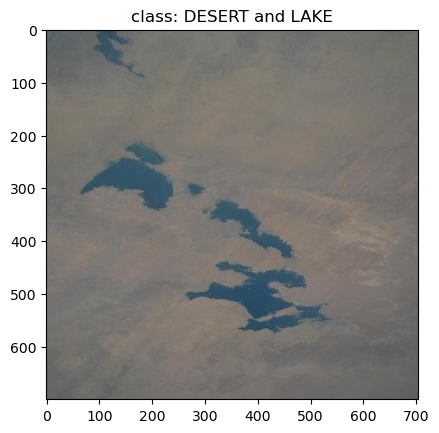

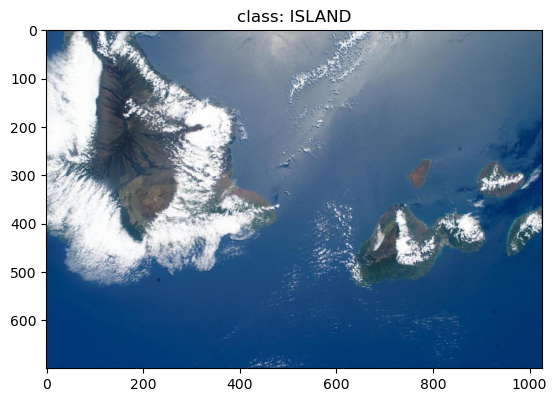

In [9]:
def img_display(path, label):
    img = cv2.imread(path)[:,:,::-1]
    plt.imshow(img)
    plt.grid(False)
    plt.title(f'class: {label}')
    plt.show()

train_imgs = [os.path.join(Config.images_path, img) for img in train_data_raw['FileName']]
train_labels = [lbl for lbl in train_data_raw['Label Vector']]
train_string_labels = [lbl for lbl in train_data_raw['Label String']]

val_imgs = [os.path.join(Config.images_path, img) for img in val_data_raw['FileName']]
val_labels = [lbl for lbl in val_data_raw['Label Vector']]
val_string_labels = [lbl for lbl in val_data_raw['Label String']]

img_display(train_imgs[0], train_string_labels[0])
img_display(val_imgs[0], val_string_labels[0])

TRAINING DATA ANALYSIS
=== INDIVIDUAL LABEL DISTRIBUTION ===
BEACH: 85 samples (6.81%)
CITY: 64 samples (5.13%)
COAST: 140 samples (11.22%)
DESERT: 436 samples (34.94%)
FOREST: 4 samples (0.32%)
ISLAND: 333 samples (26.68%)
LAKE: 152 samples (12.18%)
MOUNTAIN: 212 samples (16.99%)
RIVER: 193 samples (15.46%)
SNOW: 246 samples (19.71%)

=== LABEL COMBINATION DISTRIBUTION ===
ISLAND: 261 samples (20.91%)
MOUNTAIN and SNOW: 182 samples (14.58%)
DESERT: 173 samples (13.86%)
DESERT and LAKE: 107 samples (8.57%)
RIVER: 99 samples (7.93%)
COAST and ISLAND: 72 samples (5.77%)
COAST and DESERT: 68 samples (5.45%)
AGRICULTURE and DESERT: 54 samples (4.33%)
CITY and RIVER: 54 samples (4.33%)
LAKE and SNOW: 40 samples (3.21%)
DESERT and RIVER: 34 samples (2.72%)
AGRICULTURE: 31 samples (2.48%)
SNOW: 24 samples (1.92%)
MOUNTAIN: 24 samples (1.92%)
CITY: 10 samples (0.80%)

Total unique label combinations: 18
=== IMBALANCE METRICS ===
Imbalance Ratio (Max/Min): 109.00
Mean Per Label: 186.50
Coeffici

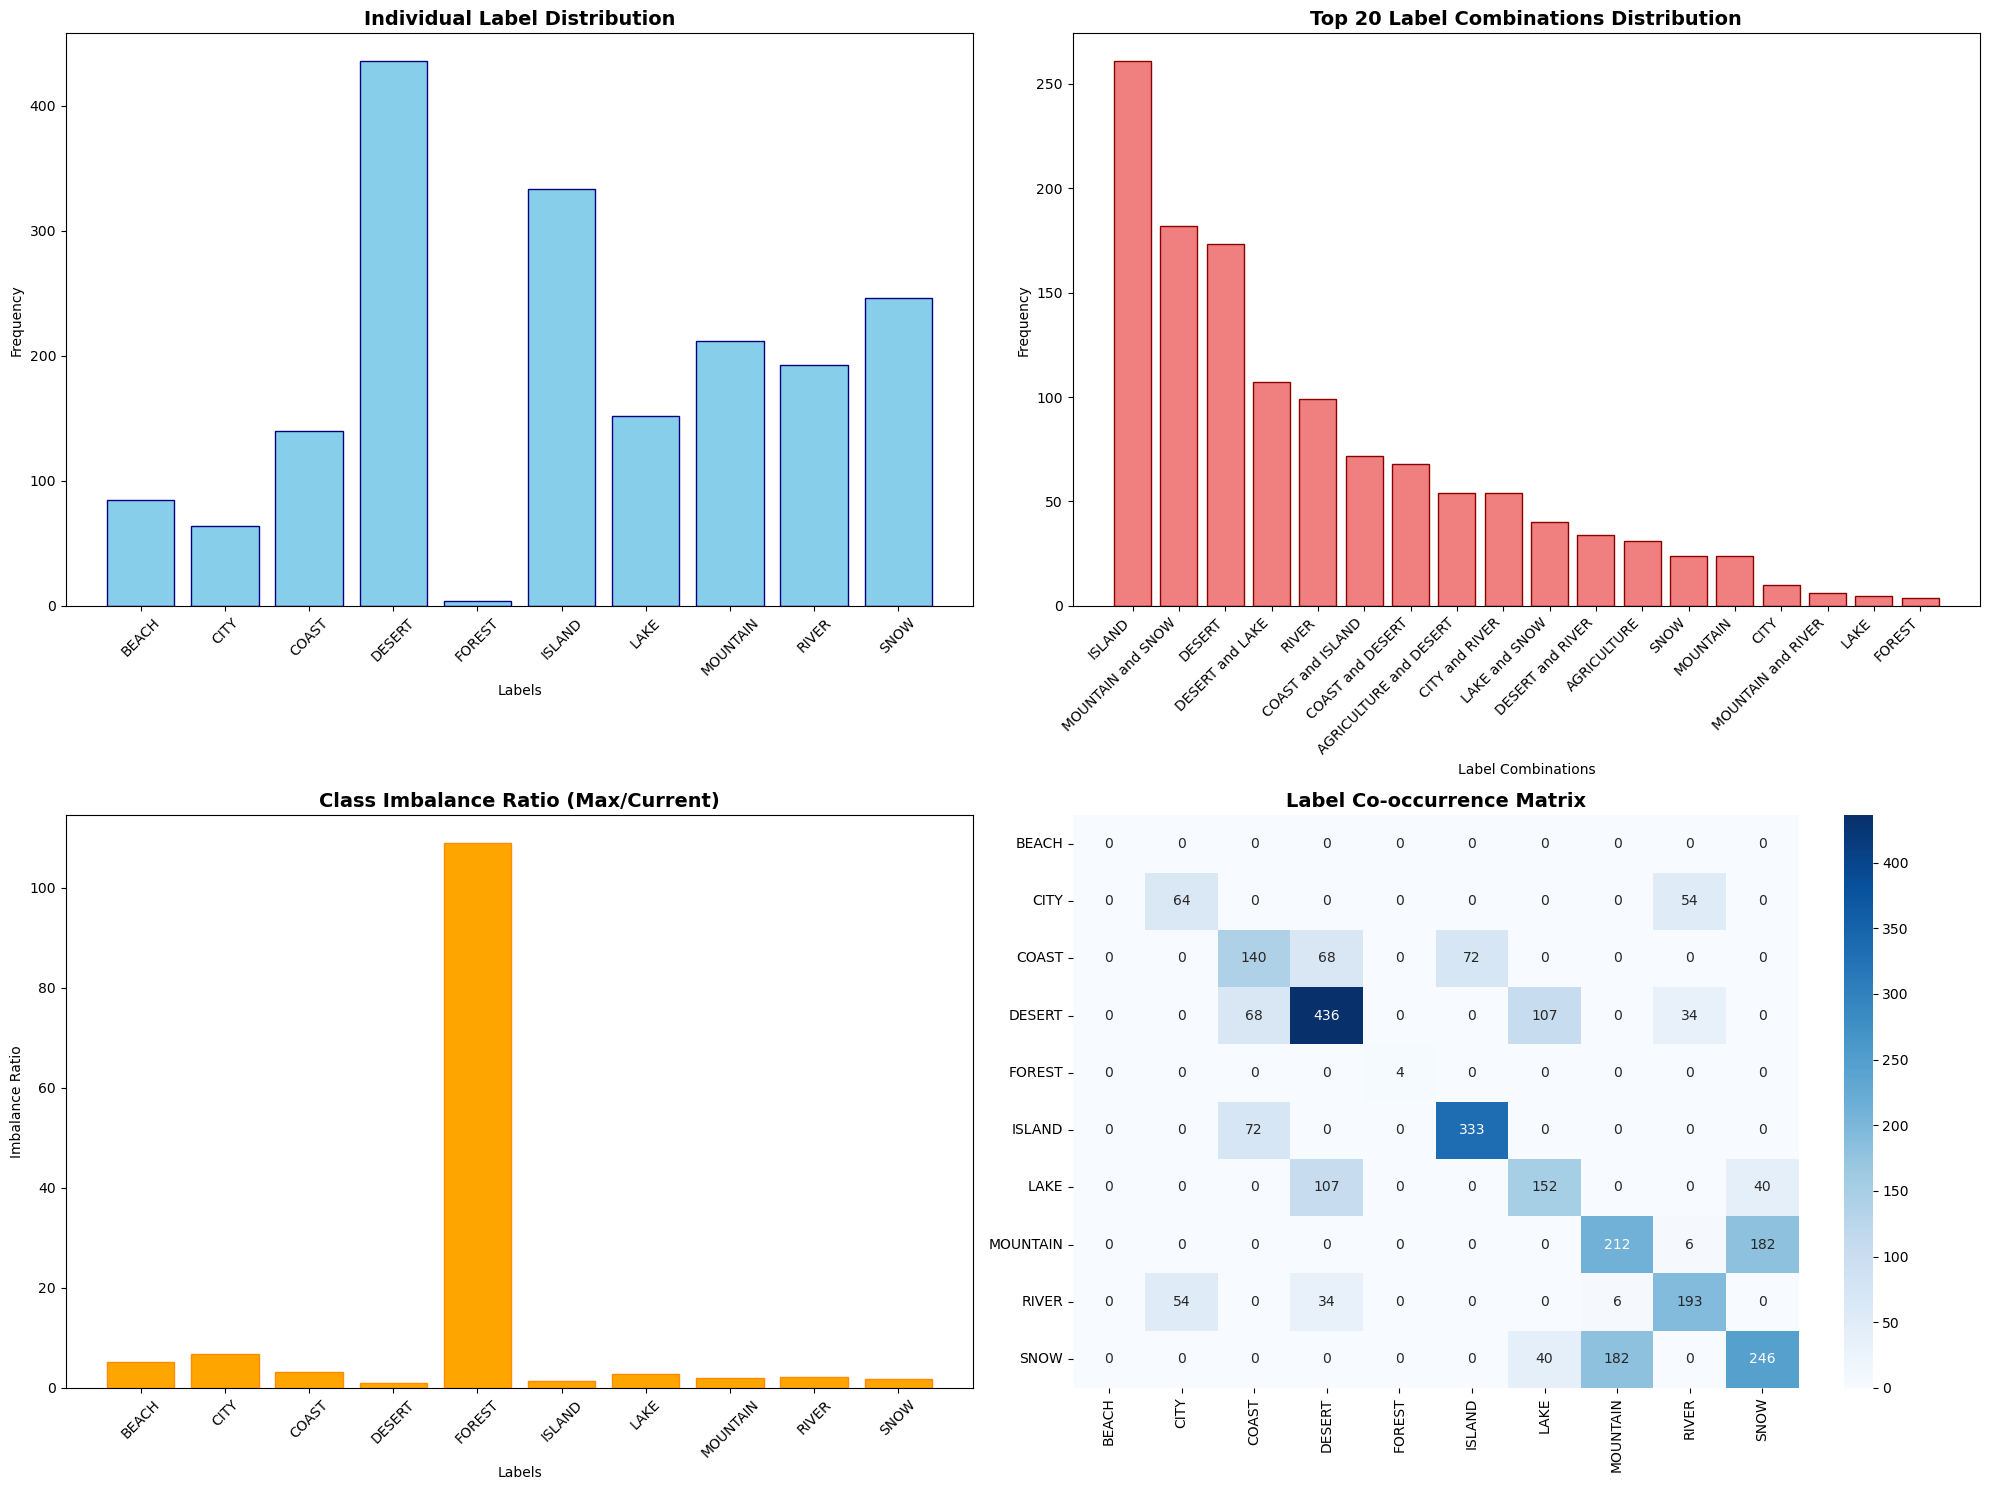

In [10]:
# Analyze class imbalance in training data
print("TRAINING DATA ANALYSIS")
print("=" * 50)
train_label_vectors, train_combinations, train_label_counts, individual_labels = analyze_label_distribution(train_data_raw)
train_metrics = calculate_imbalance_metrics(train_label_counts)

print("\n\nVALIDATION DATA ANALYSIS")
print("=" * 50)
val_label_vectors, val_combinations, val_label_counts, _ = analyze_label_distribution(val_data_raw)
val_metrics = calculate_imbalance_metrics(val_label_counts)

# Visualize the imbalance
print("\n\nVISUALIZING TRAINING DATA IMBALANCE...")
cooccurrence_matrix = visualize_class_imbalance(train_label_counts, individual_labels, train_combinations)

In [11]:
class FocalLoss(nn.Module):
    """
    Focal Loss for addressing class imbalance in multi-label classification
    """
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        
    def forward(self, inputs, targets):
        bce_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-bce_loss)
        focal_loss = self.alpha * (1-pt)**self.gamma * bce_loss
        
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

class WeightedBCEWithLogitsLoss(nn.Module):
    """
    Weighted Binary Cross Entropy Loss to handle class imbalance
    """
    def __init__(self, pos_weights=None):
        super(WeightedBCEWithLogitsLoss, self).__init__()
        self.pos_weights = pos_weights
        
    def forward(self, inputs, targets):
        if self.pos_weights is not None:
            loss = F.binary_cross_entropy_with_logits(
                inputs, targets, pos_weight=self.pos_weights
            )
        else:
            loss = F.binary_cross_entropy_with_logits(inputs, targets)
        return loss

def calculate_pos_weights(label_counts, strategy='inverse_freq'):
    """
    Calculate positive weights for weighted loss
    """
    total_samples = len(train_data_raw)
    
    if strategy == 'inverse_freq':
        # Inverse frequency weighting
        pos_weights = total_samples / (2 * label_counts)
    elif strategy == 'effective_num':
        # Effective number of samples weighting
        beta = 0.9999
        effective_num = 1.0 - np.power(beta, label_counts)
        pos_weights = (1.0 - beta) / effective_num
    else:
        # Balanced weighting
        neg_counts = total_samples - label_counts
        pos_weights = neg_counts / label_counts
    
    return torch.FloatTensor(pos_weights)

# Calculate positive weights for the loss function
pos_weights = calculate_pos_weights(train_label_counts, strategy='inverse_freq')
print("\nCalculated positive weights for each class:")
for i, (label, weight) in enumerate(zip(individual_labels, pos_weights)):
    print(f"{label}: {weight:.3f}")

# Create weighted loss function
weighted_criterion = WeightedBCEWithLogitsLoss(pos_weights=pos_weights.to(Config.device) if torch.cuda.is_available() else pos_weights)
focal_criterion = FocalLoss(alpha=1, gamma=2)


Calculated positive weights for each class:
BEACH: 7.341
CITY: 9.750
COAST: 4.457
DESERT: 1.431
FOREST: 156.000
ISLAND: 1.874
LAKE: 4.105
MOUNTAIN: 2.943
RIVER: 3.233
SNOW: 2.537


## Data Imbalance
Data imbalance in multilabel classification presents a distinct challenge that differs from binary or multiclass settings. This imbalance occurs in two distinct forms: label-level imbalance and label-combination imbalance. Label-level imbalance arises when certain individual labels appear significantly less frequently than others. In contrast, label-combination imbalance occurs when specific combinations of labels co-occur rarely, making it difficult for models to learn effective representations for these infrequent label combinations.

We recommend reading through [Handling Data Imbalance for MultiLabel Classification](https://medium.com/thecyphy/handling-data-imbalance-in-multi-label-classification-mlsmote-531155416b87). This is a great way to get started. Another great way to handle data imbalance is by using [Focal Loss](https://docs.pytorch.org/vision/main/generated/torchvision.ops.sigmoid_focal_loss.html). 

There are many different strategies that can be implemented to solve this issue. We recommend experimenting with different options and seeing which ones provide the most promising results. 

## Helper Functions

In [12]:
def resize_normalize(img):
    """
    Argument: image
    steps: 1. Resize image to specified dimensions
           2. transpose so that channels are first
           3. resize image
    """
    img = cv2.resize(img, Config.img_dimensions)
    
    #ret,img = cv2.threshold(img,127,255,cv2.THRESH_BINARY)
    img = np.transpose(img, (2,0,1)) # reorder it to channels first
    img = torch.from_numpy(img).float()
    img = img / 255
    
    return img
    
def to_numpy(x):
    return x.detach().cpu().numpy()

## Custom Image Dataset

A PyTorch Custom Image Dataset is a class that inherits from PyTorch's Dataset class which provides a way to create a dataset that is tailored to your requirements and needs. It integrates efficiently with PyTorch's DataLoader, allowing us to load and process images in batches during model training and validation

#### What is it used for?
- Data Loading: Standardized way to load images and labels from disk.
- Data Preprocessing: Consistent application of transformations (resizing, augmentation, etc.) to images.
- Batch Creation: Mini-batch generation for training.
- Memory Efficiency: Load images only when needed rather than storing entire dataset in memory. 

Provided below is a custom image dataset that you may use for this challenge. You may add your own modifications by reading through [PyTorch's documentation](https://docs.pytorch.org/tutorials/beginner/basics/data_tutorial.html). 

In [13]:
class CustomImageDataset(Dataset):
    def __init__(self, dataset, img_dir, transform=None, target_transform=None):
        self.dataset = dataset.reset_index(drop=True)  # Reset index to avoid issues
        self.image_labels = list(dataset['Label Vector'])
        self.image_path = list(dataset['FileName'])
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        
    def __len__(self):
        return len(self.dataset)
        
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.dataset.iloc[idx]['FileName'])
        image = cv2.imread(img_path)
        
        if image is None:
            raise ValueError(f"Could not load image: {img_path}")
            
        # Convert BGR to RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Apply resize and normalize if no transform, otherwise let transform handle it
        if self.transform is None:
            image = resize_normalize(image)
        else:
            # For transforms that expect PIL/tensor format
            image = self.transform(image)
        
        # Get label
        label = self.dataset.iloc[idx]['Label Vector']
        label = torch.tensor(eval(label), dtype=torch.float32)
        
        if self.target_transform:
            label = self.target_transform(label)
            
        return image, label

### Image Augmentation

Image augmentation is an absolutely wonderful way to artificially expand your training dataset, which is especially valuable when working with limited data — a common constraint in real-world image tasks. By creating variations of existing images through transformations like rotations, flips, zooms, and crops, you essentially teach your CNN to recognize objects under different viewing conditions without collecting additional data.

More fundamentally, augmentation directly addresses overfitting by preventing the network from memorizing exact pixel patterns. When a CNN sees the same exact images repeatedly, it tends to learn specific pixel configurations rather than generalizable features. By presenting slightly different versions each time, you force the network to learn robust representations that capture the essence of objects rather than superficial details.

Augmentation also introduces invariance properties into your model. For classification tasks, whether an image is slightly rotated, zoomed, or shifted shouldn't change the label. By training with these variations, your CNN develops translation, rotation, and scale invariance—crucial properties for real-world deployment where objects rarely appear in perfectly consistent positions or orientations.

The CustomImageDataset created above is setup to handle image transforms. A blank example is provided below. See documentation [here](https://docs.pytorch.org/vision/stable/transforms.html?highlight=compose)


In [14]:
# class CustomImageDataset(Dataset):
#     def __init__(self, data, image_dir, transform=None):
#         self.data = data
#         self.image_dir = image_dir
#         self.transform = transform

#     def __len__(self):
#         return len(self.data)

#     def __getitem__(self, idx):
#         # Load image and label
#         image_path = os.path.join(self.image_dir, self.data[idx]['filename'])
#         image = Image.open(image_path).convert('RGB')  # PIL image
#         label = self.data[idx]['label']

#         # Apply transform
#         if self.transform:
#             image = self.transform(image)

#         return image, label


In [15]:
# import albumentations as A
# from albumentations.pytorch import ToTensorV2
# import numpy as np

# class AlbumentationsTransform:
#     def __init__(self, aug):
#         self.aug = aug

#     def __call__(self, image):
#         # Convert PIL to numpy
#         image = np.array(image)
#         augmented = self.aug(image=image)
#         return augmented['image']


In [16]:
# import albumentations as A
# from albumentations.pytorch import ToTensorV2

# albumentations_transform = AlbumentationsTransform(
#     A.Compose([
#         A.Resize(256, 256),
#         A.RandomCrop(224, 224),
#         A.HorizontalFlip(p=0.5),
#         A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
#         ToTensorV2()
#     ])
# )


In [17]:
# Enhanced but careful augmentation strategy
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256, 256)),  # Slightly larger for random crop
    transforms.RandomCrop((224, 224)),  # Random crop to target size
    transforms.RandomHorizontalFlip(p=0.5),  # Geometric
    transforms.RandomVerticalFlip(p=0.3),    # Geometric (lower prob for geographical data)
    transforms.RandomRotation(degrees=10),   # Small rotation
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),  # Geometric transforms
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),  # Minimal color changes
    transforms.ToTensor(),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 1.0)),  # Occasional blur
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 1.0))], p=0.3),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
])

# Validation transform (no augmentation)
val_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_ds = CustomImageDataset(train_data_raw, Config.images_path, transform=train_transform)
valid_ds = CustomImageDataset(val_data_raw, Config.images_path, transform=val_transform)

### CNN Model Architecture

There are two ways to approaching the model architecture phase of the problem. 

1. Building your own CNN architecture. An example is provided below where modifications can be made. 
2. Using pretrained models.

### Building Your Own CNN Architecture

__Advantages:__

- Complete control over the architecture design. 
- Freedom to experiment with novel layer arrangements, activation functions, and skip connections.
- No constraints from pretrained weights or architectures that may not be optimal for your domain.
- Typically results in a smaller, more compute efficient model since you only include what you need.

__Disadvantages:__

- Requires a bit more expertise and understanding of Neural Network design
- More epochs are needed as learning must start from random initialization
- Needs much more data to achieve good performance (often prohibitively large amounts)
- Higher risk of overfitting, especially with limited data

### Using Pretrained Models

__Advantages:__

- Leverage powerful feature extractors trained on massive datasets (like ImageNet with 1.2M images)
- Dramatically reduced training time and computational requirements (though more compute resources are needed to get started)
- Excellent performance even with limited domain-specific data
- Built-in robustness against common image variations and noise
- Access to state-of-the-art architectures (ResNet, EfficientNet, Vision Transformers) without designing them

__Disadvantages:__

- Less control over the underlying architecture
- May include unnecessary complexity for simpler tasks
- Domain shift can be problematic if your images differ significantly from pretraining data
- Fixed input requirements (resolution, channels) that may require preprocessing



In [18]:
class EnhancedCNNModel(nn.Module):
    def __init__(self, num_classes=10, dropout_rate=0.3):
        super(EnhancedCNNModel, self).__init__()
        
        # First block
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(2, 2)
        
        # Second block
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(2, 2)
        
        # Third block
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(256)
        self.conv6 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(2, 2)
        
        # Fourth block
        self.conv7 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn7 = nn.BatchNorm2d(512)
        self.conv8 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn8 = nn.BatchNorm2d(512)
        self.pool4 = nn.MaxPool2d(2, 2)
        
        # Global Average Pooling
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        # Classifier
        self.dropout = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(512, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_classes)
        
    def forward(self, x):
        # First block
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x)
        
        # Second block
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool2(x)
        
        # Third block
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))
        x = self.pool3(x)
        
        # Fourth block
        x = F.relu(self.bn7(self.conv7(x)))
        x = F.relu(self.bn8(self.conv8(x)))
        x = self.pool4(x)
        
        # Global pooling and classifier
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x

# Original CNN Model (keeping for comparison)
class CNNModel(nn.Module):
    def __init__(self, num_classes=10):
        super(CNNModel, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(50176, 1024)  # Updated for 224x224 input
        self.fc2 = nn.Linear(1024, num_classes)
        
    def forward(self, x):
        # Convolutional layers with ReLU activation and batch normalization
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.pool3(x)

        # Flatten the output
        x = x.view(x.size(0), -1)
        
        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

In [19]:
from timm import create_model
from huggingface_hub import hf_hub_download

# Download pretrained weights (pytorch_model.bin) from HuggingFace
ckpt_path = hf_hub_download(repo_id="cm93/resnet50-eurosat", filename="pytorch_model.bin")

# Initialize ResNet-50 for 10 classes
pt_model = create_model('resnet50', pretrained=False, num_classes=10)
pt_model.load_state_dict(torch.load(ckpt_path, map_location=torch.device('cuda')))

print("Model successfully loaded on GPU")

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

Model successfully loaded on GPU


In [34]:
ckpt = torch.load("satclip-resnet50-l40.ckpt", map_location="cpu")
pt_model = get_satclip(ckpt, device="cuda" if torch.cuda.is_available() else "cpu")

print("Model successfully loaded on GPU")


FileNotFoundError: [Errno 2] No such file or directory: 'satclip-resnet50-l40.ckpt'

## Model Training

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

def train_model_enhanced(
    model, train_ds, valid_ds, epochs, learning_rate, num_classes, version, use_focal_loss=False
):
    os.makedirs('model_checkpoints/', exist_ok=True)
    torch.manual_seed(39) # set seed
    model = model.to(Config.device)
    model_name = model.__class__.__name__
    print(f"Model: {model_name}")
    
    workers = min(os.cpu_count() - 1, 4)
    train_dataloader = DataLoader(
        train_ds, batch_size=Config.batch_size, shuffle=True, 
        num_workers=workers, prefetch_factor=6, pin_memory=True
    )
    valid_dataloader = DataLoader(
        valid_ds, batch_size=Config.batch_size, shuffle=False, 
        num_workers=workers, prefetch_factor=6, pin_memory=True
    )
    
    # Choose loss function
    if use_focal_loss:
        criterion = FocalLoss(alpha=1, gamma=2)
        print("Using Focal Loss")
    else:
        criterion = weighted_criterion
        print("Using Weighted BCE Loss")
    
    # Enhanced optimizer with better weight decay
    optimizer = torch.optim.AdamW(
        model.parameters(), lr=learning_rate, 
        weight_decay=Config.weight_decay, betas=(0.9, 0.999)
    )
    
    # Learning rate scheduler
    scheduler = ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=5, 
        min_lr=1e-6, verbose=True
    )
    
    # Training history
    history = {
        'train_loss': [], 'val_loss': [], 
        'train_f1': [], 'val_f1': [],
        'learning_rates': []
    }
    
    best_val_f1 = 0.0
    patience_counter = 0
    
    for epoch in range(1, epochs + 1):
        # Training phase
        model.train()
        train_loss = 0.0
        train_f1 = 0.0
        
        for x_batch, y_batch in tqdm(train_dataloader, desc=f"Epoch {epoch}/{epochs} - Training"):
            x_batch = x_batch.to(Config.device)
            y_batch = y_batch.to(Config.device)
            
            optimizer.zero_grad()
            pred = model(x_batch)
            loss = criterion(pred, y_batch.float())
            loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            
            train_loss += loss.item()
            
            # Calculate F1 score
            with torch.no_grad():
                pred_sigmoid = torch.sigmoid(pred)
                pred_binary = (pred_sigmoid > Config.threshold).float()
                batch_f1 = f1_score(
                    to_numpy(pred_binary), to_numpy(y_batch), 
                    average='micro', zero_division=0
                )
                train_f1 += batch_f1
        
        # Average training metrics
        train_loss /= len(train_dataloader)
        train_f1 /= len(train_dataloader)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_f1 = 0.0
        
        with torch.no_grad():
            for x_val, y_val in tqdm(valid_dataloader, desc=f"Epoch {epoch}/{epochs} - Validation"):
                x_val = x_val.to(Config.device)
                y_val = y_val.to(Config.device)
                
                pred = model(x_val)
                loss = criterion(pred, y_val.float())
                val_loss += loss.item()
                
                pred_sigmoid = torch.sigmoid(pred)
                pred_binary = (pred_sigmoid > Config.threshold).float()
                batch_f1 = f1_score(
                    to_numpy(pred_binary), to_numpy(y_val), 
                    average='micro', zero_division=0
                )
                val_f1 += batch_f1
        
        # Average validation metrics
        val_loss /= len(valid_dataloader)
        val_f1 /= len(valid_dataloader)
        
        # Learning rate scheduling
        scheduler.step(val_loss)
        current_lr = optimizer.param_groups[0]['lr']
        
        # Save history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_f1'].append(train_f1)
        history['val_f1'].append(val_f1)
        history['learning_rates'].append(current_lr)
        
        # Print metrics
        print(f"Epoch {epoch}/{epochs}:")
        print(f"Train Loss: {train_loss:.4f}, Train F1: {train_f1:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val F1: {val_f1:.4f}")
        print(f"Learning Rate: {current_lr:.6f}")
        
        # Save best model
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            # Create a serializable config dict
            config_dict = {
                'img_dimensions': Config.img_dimensions,
                'batch_size': Config.batch_size,
                'initial_learning_rate': Config.initial_learning_rate,
                'num_epochs': Config.num_epochs,
                'weight_decay': Config.weight_decay,
                'threshold': Config.threshold,
                'patience': Config.patience
            }
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'epoch': epoch,
                'best_val_f1': best_val_f1,
                'config': config_dict
            }, f'model_checkpoints/best_model_{version}_{model_name}.pt')
            patience_counter = 0
            print(f"New best validation F1: {best_val_f1:.4f}")
        else:
            patience_counter += 1
        
        # Early stopping
        if patience_counter >= Config.patience:
            print(f"Early stopping triggered after {Config.patience} epochs without improvement")
            break
        
        print("-" * 50)
    
    # Load best model
    checkpoint = torch.load(f'model_checkpoints/best_model_{version}_{model_name}.pt')
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    
    print(f"Training completed. Best validation F1: {best_val_f1:.4f}")
    
    return model, history

In [21]:
# Train with the enhanced function and Focal Loss for better handling of class imbalance
model, history = train_model_enhanced(
    pt_model, train_ds, valid_ds, 
    Config.num_epochs, 
    learning_rate=Config.initial_learning_rate, 
    num_classes=10, 
    version=1,
    use_focal_loss=True  # Use Focal Loss for better class imbalance handling
)

# Extract metrics from history for compatibility with visualization
f1_hist_train = history['train_f1']
f1_hist_val = history['val_f1']
train_losses = history['train_loss']
val_losses = history['val_loss']

Model: ResNet
Using Focal Loss


Epoch 1/50 - Validation: 100%|██████████| 48/48 [00:02<00:00, 17.09it/s]


Epoch 1/50:
Train Loss: 0.0727, Train F1: 0.6314
Val Loss: 0.0393, Val F1: 0.7980
Learning Rate: 0.001000
New best validation F1: 0.7980
--------------------------------------------------


Epoch 2/50 - Validation: 100%|██████████| 48/48 [00:02<00:00, 18.16it/s]


Epoch 2/50:
Train Loss: 0.0408, Train F1: 0.7865
Val Loss: 0.0303, Val F1: 0.8474
Learning Rate: 0.001000
New best validation F1: 0.8474
--------------------------------------------------


Epoch 3/50 - Validation: 100%|██████████| 48/48 [00:02<00:00, 18.33it/s]


Epoch 3/50:
Train Loss: 0.0344, Train F1: 0.8210
Val Loss: 0.0280, Val F1: 0.8557
Learning Rate: 0.001000
New best validation F1: 0.8557
--------------------------------------------------


Epoch 4/50 - Validation: 100%|██████████| 48/48 [00:02<00:00, 17.71it/s]


Epoch 4/50:
Train Loss: 0.0298, Train F1: 0.8494
Val Loss: 0.0295, Val F1: 0.8542
Learning Rate: 0.001000
--------------------------------------------------


Epoch 5/50 - Validation: 100%|██████████| 48/48 [00:02<00:00, 17.72it/s]


Epoch 5/50:
Train Loss: 0.0273, Train F1: 0.8556
Val Loss: 0.0228, Val F1: 0.8925
Learning Rate: 0.001000
New best validation F1: 0.8925
--------------------------------------------------


Epoch 6/50 - Validation: 100%|██████████| 48/48 [00:02<00:00, 17.89it/s]


Epoch 6/50:
Train Loss: 0.0241, Train F1: 0.8753
Val Loss: 0.0210, Val F1: 0.8940
Learning Rate: 0.001000
New best validation F1: 0.8940
--------------------------------------------------


Epoch 7/50 - Validation: 100%|██████████| 48/48 [00:02<00:00, 17.74it/s]


Epoch 7/50:
Train Loss: 0.0208, Train F1: 0.8950
Val Loss: 0.0233, Val F1: 0.8906
Learning Rate: 0.001000
--------------------------------------------------


Epoch 8/50 - Validation: 100%|██████████| 48/48 [00:02<00:00, 17.43it/s]


Epoch 8/50:
Train Loss: 0.0198, Train F1: 0.9000
Val Loss: 0.0227, Val F1: 0.8897
Learning Rate: 0.001000
--------------------------------------------------


Epoch 9/50 - Validation: 100%|██████████| 48/48 [00:02<00:00, 17.75it/s]


Epoch 9/50:
Train Loss: 0.0168, Train F1: 0.9121
Val Loss: 0.0211, Val F1: 0.8996
Learning Rate: 0.001000
New best validation F1: 0.8996
--------------------------------------------------


Epoch 10/50 - Validation: 100%|██████████| 48/48 [00:02<00:00, 18.07it/s]


Epoch 10/50:
Train Loss: 0.0157, Train F1: 0.9156
Val Loss: 0.0246, Val F1: 0.8984
Learning Rate: 0.001000
--------------------------------------------------


Epoch 11/50 - Validation: 100%|██████████| 48/48 [00:02<00:00, 17.59it/s]


Epoch 11/50:
Train Loss: 0.0155, Train F1: 0.9218
Val Loss: 0.0246, Val F1: 0.9062
Learning Rate: 0.001000
New best validation F1: 0.9062
--------------------------------------------------


Epoch 12/50 - Validation: 100%|██████████| 48/48 [00:02<00:00, 17.82it/s]


Epoch 12/50:
Train Loss: 0.0169, Train F1: 0.9159
Val Loss: 0.0236, Val F1: 0.8906
Learning Rate: 0.000500
--------------------------------------------------


Epoch 13/50 - Validation: 100%|██████████| 48/48 [00:02<00:00, 18.04it/s]


Epoch 13/50:
Train Loss: 0.0105, Train F1: 0.9447
Val Loss: 0.0211, Val F1: 0.9175
Learning Rate: 0.000500
New best validation F1: 0.9175
--------------------------------------------------


Epoch 14/50 - Validation: 100%|██████████| 48/48 [00:02<00:00, 18.14it/s]


Epoch 14/50:
Train Loss: 0.0089, Train F1: 0.9556
Val Loss: 0.0231, Val F1: 0.9209
Learning Rate: 0.000500
New best validation F1: 0.9209
--------------------------------------------------


Epoch 15/50 - Validation: 100%|██████████| 48/48 [00:02<00:00, 18.16it/s]


Epoch 15/50:
Train Loss: 0.0067, Train F1: 0.9679
Val Loss: 0.0220, Val F1: 0.9156
Learning Rate: 0.000500
--------------------------------------------------


Epoch 16/50 - Validation: 100%|██████████| 48/48 [00:02<00:00, 17.65it/s]


Epoch 16/50:
Train Loss: 0.0086, Train F1: 0.9542
Val Loss: 0.0219, Val F1: 0.9186
Learning Rate: 0.000500
--------------------------------------------------


Epoch 17/50 - Validation: 100%|██████████| 48/48 [00:02<00:00, 17.86it/s]


Epoch 17/50:
Train Loss: 0.0071, Train F1: 0.9653
Val Loss: 0.0266, Val F1: 0.9103
Learning Rate: 0.000500
--------------------------------------------------


Epoch 18/50 - Validation: 100%|██████████| 48/48 [00:02<00:00, 17.92it/s]


Epoch 18/50:
Train Loss: 0.0059, Train F1: 0.9663
Val Loss: 0.0260, Val F1: 0.9183
Learning Rate: 0.000250
--------------------------------------------------


Epoch 19/50 - Validation: 100%|██████████| 48/48 [00:02<00:00, 17.64it/s]


Epoch 19/50:
Train Loss: 0.0051, Train F1: 0.9726
Val Loss: 0.0246, Val F1: 0.9193
Learning Rate: 0.000250
--------------------------------------------------


Epoch 20/50 - Validation: 100%|██████████| 48/48 [00:02<00:00, 17.91it/s]


Epoch 20/50:
Train Loss: 0.0037, Train F1: 0.9825
Val Loss: 0.0239, Val F1: 0.9273
Learning Rate: 0.000250
New best validation F1: 0.9273
--------------------------------------------------


Epoch 21/50 - Validation: 100%|██████████| 48/48 [00:02<00:00, 18.18it/s]


Epoch 21/50:
Train Loss: 0.0050, Train F1: 0.9737
Val Loss: 0.0251, Val F1: 0.9198
Learning Rate: 0.000250
--------------------------------------------------


Epoch 22/50 - Validation: 100%|██████████| 48/48 [00:02<00:00, 17.88it/s]


Epoch 22/50:
Train Loss: 0.0042, Train F1: 0.9797
Val Loss: 0.0278, Val F1: 0.9235
Learning Rate: 0.000250
--------------------------------------------------


Epoch 23/50 - Validation: 100%|██████████| 48/48 [00:02<00:00, 17.60it/s]


Epoch 23/50:
Train Loss: 0.0030, Train F1: 0.9853
Val Loss: 0.0273, Val F1: 0.9199
Learning Rate: 0.000250
--------------------------------------------------


Epoch 24/50 - Validation: 100%|██████████| 48/48 [00:02<00:00, 17.76it/s]


Epoch 24/50:
Train Loss: 0.0049, Train F1: 0.9804
Val Loss: 0.0266, Val F1: 0.9177
Learning Rate: 0.000125
--------------------------------------------------


Epoch 25/50 - Validation: 100%|██████████| 48/48 [00:02<00:00, 17.58it/s]


Epoch 25/50:
Train Loss: 0.0025, Train F1: 0.9884
Val Loss: 0.0263, Val F1: 0.9258
Learning Rate: 0.000125
--------------------------------------------------


Epoch 26/50 - Validation: 100%|██████████| 48/48 [00:02<00:00, 17.88it/s]


Epoch 26/50:
Train Loss: 0.0031, Train F1: 0.9839
Val Loss: 0.0272, Val F1: 0.9234
Learning Rate: 0.000125
--------------------------------------------------


Epoch 27/50 - Validation: 100%|██████████| 48/48 [00:02<00:00, 17.82it/s]


Epoch 27/50:
Train Loss: 0.0029, Train F1: 0.9864
Val Loss: 0.0245, Val F1: 0.9269
Learning Rate: 0.000125
Early stopping triggered after 7 epochs without improvement
Training completed. Best validation F1: 0.9273


## Visualize Metrics

Finding optimal threshold...


Threshold: 0.10, F1: 0.8314
Threshold: 0.15, F1: 0.8691
Threshold: 0.20, F1: 0.8942
Threshold: 0.25, F1: 0.9096
Threshold: 0.30, F1: 0.9180
Threshold: 0.35, F1: 0.9286
Threshold: 0.40, F1: 0.9285
Threshold: 0.45, F1: 0.9302
Threshold: 0.50, F1: 0.9320
Threshold: 0.55, F1: 0.9313
Threshold: 0.60, F1: 0.9294
Threshold: 0.65, F1: 0.9262
Threshold: 0.70, F1: 0.9204
Threshold: 0.75, F1: 0.9073
Threshold: 0.80, F1: 0.8874
Threshold: 0.85, F1: 0.8696

Optimal threshold: 0.50 with F1: 0.9320


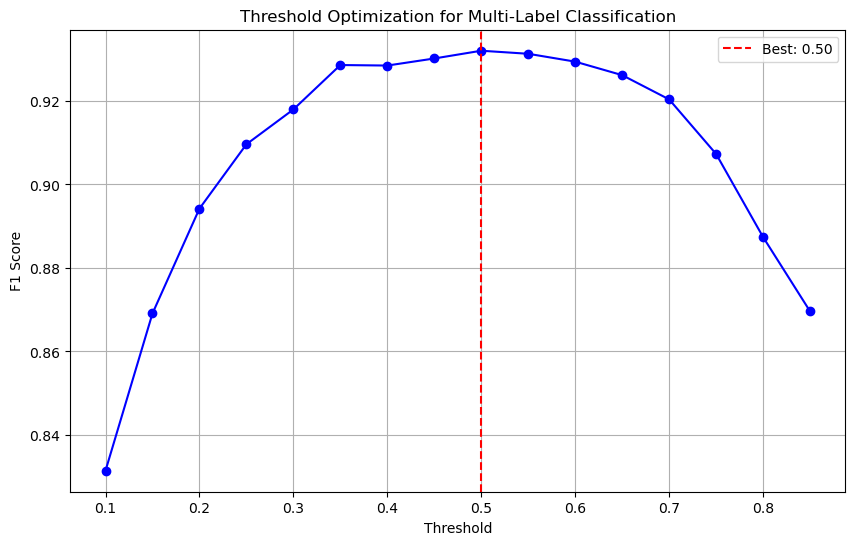

Updated threshold to: 0.5000000000000001


In [22]:
# Find optimal threshold after training
print("Finding optimal threshold...")
valid_dataloader = DataLoader(
    valid_ds, batch_size=Config.batch_size, shuffle=False, 
    num_workers=4, prefetch_factor=4, pin_memory=True
)

optimal_threshold, best_f1_threshold = find_optimal_threshold(model, valid_dataloader)

# Update config with optimal threshold
Config.threshold = optimal_threshold
print(f"Updated threshold to: {Config.threshold}")


In [23]:
# Test Time Augmentation (TTA) for improved predictions
def test_time_augmentation(model, dataloader, num_tta=5):
    """
    Apply test time augmentation to improve predictions
    """
    model.eval()
    all_predictions = []
    all_labels = []
    
    # TTA transforms
    tta_transforms = [
        transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.3),
            transforms.RandomRotation(degrees=5),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ]) for _ in range(num_tta)
    ]
    
    with torch.no_grad():
        for x, y in tqdm(dataloader, desc="TTA Predictions"):
            batch_predictions = []
            
            # Original prediction
            x_orig = x.to(Config.device)
            pred_orig = torch.sigmoid(model(x_orig))
            batch_predictions.append(to_numpy(pred_orig))
            
            # TTA predictions
            for i in range(num_tta):
                # Apply augmentation to each image in batch
                x_aug_batch = []
                for img_idx in range(x.shape[0]):
                    # Convert tensor back to PIL for augmentation
                    img_np = to_numpy(x[img_idx].permute(1, 2, 0))
                    img_np = (img_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])) * 255
                    img_np = np.clip(img_np, 0, 255).astype(np.uint8)
                    
                    # Apply TTA transform
                    img_aug = tta_transforms[i](img_np)
                    x_aug_batch.append(img_aug)
                
                x_aug = torch.stack(x_aug_batch).to(Config.device)
                pred_aug = torch.sigmoid(model(x_aug))
                batch_predictions.append(to_numpy(pred_aug))
            
            # Average all predictions
            avg_prediction = np.mean(batch_predictions, axis=0)
            all_predictions.append(avg_prediction)
            all_labels.append(to_numpy(y))
    
    return np.vstack(all_predictions), np.vstack(all_labels)

print("Test Time Augmentation function ready!")

Test Time Augmentation function ready!


In [24]:
# Model Ensemble for improved performance
def ensemble_predictions(models, dataloader, weights=None):
    """
    Combine predictions from multiple models
    """
    if weights is None:
        weights = [1.0 / len(models)] * len(models)
    
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for x, y in tqdm(dataloader, desc="Ensemble Predictions"):
            x = x.to(Config.device)
            batch_predictions = []
            
            # Get predictions from each model
            for i, model in enumerate(models):
                model.eval()
                pred = torch.sigmoid(model(x))
                weighted_pred = to_numpy(pred) * weights[i]
                batch_predictions.append(weighted_pred)
            
            # Average weighted predictions
            ensemble_pred = np.sum(batch_predictions, axis=0)
            all_predictions.append(ensemble_pred)
            all_labels.append(to_numpy(y))
    
    return np.vstack(all_predictions), np.vstack(all_labels)

print("Ensemble prediction function ready!")

Ensemble prediction function ready!


In [25]:
# Advanced threshold optimization with per-class thresholds
def find_optimal_per_class_thresholds(model, valid_dataloader, num_classes=10):
    """
    Find optimal threshold for each class separately
    """
    model.eval()
    
    # Collect all predictions and labels
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for x, y in tqdm(valid_dataloader, desc="Collecting predictions for per-class optimization"):
            x, y = x.to(Config.device), y.to(Config.device)
            pred = model(x)
            pred_sigmoid = torch.sigmoid(pred)
            
            all_preds.append(to_numpy(pred_sigmoid))
            all_labels.append(to_numpy(y))
    
    all_preds = np.vstack(all_preds)
    all_labels = np.vstack(all_labels)
    
    # Find optimal threshold for each class
    optimal_thresholds = []
    best_f1_scores = []
    
    for class_idx in range(num_classes):
        best_threshold = 0.5
        best_f1 = 0.0
        
        for threshold in np.arange(0.1, 0.9, 0.05):
            pred_binary = (all_preds[:, class_idx] > threshold).astype(int)
            f1 = f1_score(all_labels[:, class_idx], pred_binary, zero_division=0)
            
            if f1 > best_f1:
                best_f1 = f1
                best_threshold = threshold
        
        optimal_thresholds.append(best_threshold)
        best_f1_scores.append(best_f1)
        print(f"Class {class_idx}: Optimal threshold = {best_threshold:.2f}, F1 = {best_f1:.4f}")
    
    # Test overall performance with per-class thresholds
    pred_binary_optimized = np.zeros_like(all_preds)
    for class_idx in range(num_classes):
        pred_binary_optimized[:, class_idx] = (all_preds[:, class_idx] > optimal_thresholds[class_idx]).astype(int)
    
    overall_f1 = f1_score(all_labels, pred_binary_optimized, average='micro', zero_division=0)
    print(f"\nOverall F1 with per-class thresholds: {overall_f1:.4f}")
    
    return optimal_thresholds, best_f1_scores, overall_f1

print("Per-class threshold optimization function ready!")

Per-class threshold optimization function ready!


In [26]:
# Run advanced threshold optimization
print("\n=== ADVANCED THRESHOLD OPTIMIZATION ===")
print("Finding optimal per-class thresholds...")

valid_dataloader = DataLoader(
    valid_ds, batch_size=Config.batch_size, shuffle=False, 
    num_workers=4, prefetch_factor=4, pin_memory=True
)

# Find per-class optimal thresholds
per_class_thresholds, per_class_f1s, optimized_f1 = find_optimal_per_class_thresholds(model, valid_dataloader)

# Compare with global threshold
print(f"\nComparison:")
print(f"Global threshold ({Config.threshold:.2f}): F1 = {best_f1_threshold:.4f}")
print(f"Per-class thresholds: F1 = {optimized_f1:.4f}")

if optimized_f1 > best_f1_threshold:
    print("\nUsing per-class thresholds for final evaluation!")
    Config.use_per_class_thresholds = True
    Config.per_class_thresholds = per_class_thresholds
else:
    print("\nUsing global threshold for final evaluation!")
    Config.use_per_class_thresholds = False


=== ADVANCED THRESHOLD OPTIMIZATION ===
Finding optimal per-class thresholds...


Class 0: Optimal threshold = 0.45, F1 = 0.9412
Class 1: Optimal threshold = 0.65, F1 = 0.9167
Class 2: Optimal threshold = 0.40, F1 = 0.8772
Class 3: Optimal threshold = 0.50, F1 = 0.9474
Class 4: Optimal threshold = 0.45, F1 = 0.8000
Class 5: Optimal threshold = 0.45, F1 = 0.9877
Class 6: Optimal threshold = 0.35, F1 = 0.8721
Class 7: Optimal threshold = 0.50, F1 = 0.9288
Class 8: Optimal threshold = 0.55, F1 = 0.9339
Class 9: Optimal threshold = 0.65, F1 = 0.9530

Overall F1 with per-class thresholds: 0.9391

Comparison:
Global threshold (0.50): F1 = 0.9320
Per-class thresholds: F1 = 0.9391

Using per-class thresholds for final evaluation!


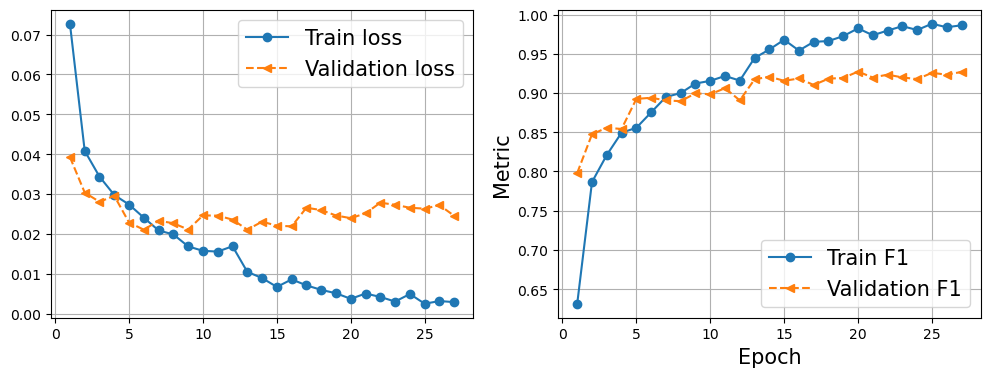

In [27]:
x_axis = np.arange(len(train_losses)) + 1
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_axis, train_losses, '-o', label = 'Train loss')
ax.plot(x_axis, val_losses, '--<', label = 'Validation loss')
ax.legend(fontsize=15)
ax.grid(True)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_axis, f1_hist_train, '-o', label='Train F1')
ax.plot(x_axis, f1_hist_val, '--<', label='Validation F1')        
ax.legend(fontsize=15)
ax.grid(True)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Metric', size=15)
plt.show()

## Grade Model (on validation set)

In [28]:
test_ds = CustomImageDataset(val_data_raw, Config.images_path, transform=val_transform)
test_dl = DataLoader(
    test_ds, batch_size=Config.batch_size, shuffle=False, num_workers=8, prefetch_factor=8,  
    pin_memory=True, persistent_workers=True
)

criterion = nn.BCEWithLogitsLoss()
actual_labels = []
predicted_labels = []
image_paths = []  # To store paths of processed images
incorrect_predictions = []  # To store (image_path, actual, predicted) for incorrect predictions

f1_test = 0.0
image_idx = 0  # Keep track of position in dataset

with torch.no_grad():
    test_loss = 0.0
    for x, y in tqdm(test_dl):
        batch_size = x.shape[0]
        x, y = x.to(Config.device), y.to(Config.device)
        pred = model(x)
        loss = criterion(pred, y.float())
        test_loss += loss.item()
        pred = torch.sigmoid(pred)
        # Convert to numpy for easier handling
        y_np = to_numpy(y)
        pred_np = to_numpy((pred > Config.threshold).int())  # Use optimized threshold
        
        # Calculate F1 score for this batch
        is_correct = f1_score(pred_np, y_np, average='micro')
        f1_test += is_correct
        
        # Store batch results
        actual_labels.append(y_np)
        predicted_labels.append(pred_np)
        
        # Check each image in the batch for correctness
        for i in range(batch_size):
            # Get the current image's index in the full dataset
            curr_idx = image_idx + i
            if curr_idx < len(test_ds):  # Ensure we don't go out of bounds
                # Get image path from test_data_raw
                img_path = val_data_raw.iloc[curr_idx]['FileName']  # Adjust column name if needed
                
                # Compare prediction with actual label
                if not np.array_equal(pred_np[i], y_np[i]):
                    # This is an incorrect prediction
                    incorrect_predictions.append({
                        'image_path': img_path,
                        'actual': y_np[i],
                        'predicted': pred_np[i]
                    })
        
        # Update image index for next batch
        image_idx += batch_size
        
    f1_test /= np.ceil(len(test_dl.dataset)/Config.batch_size)
print(f'Validation F1: {f1_test}')

100%|██████████| 48/48 [00:02<00:00, 18.05it/s]

Validation F1: 0.9306157585564964


## Where the model is underperforming

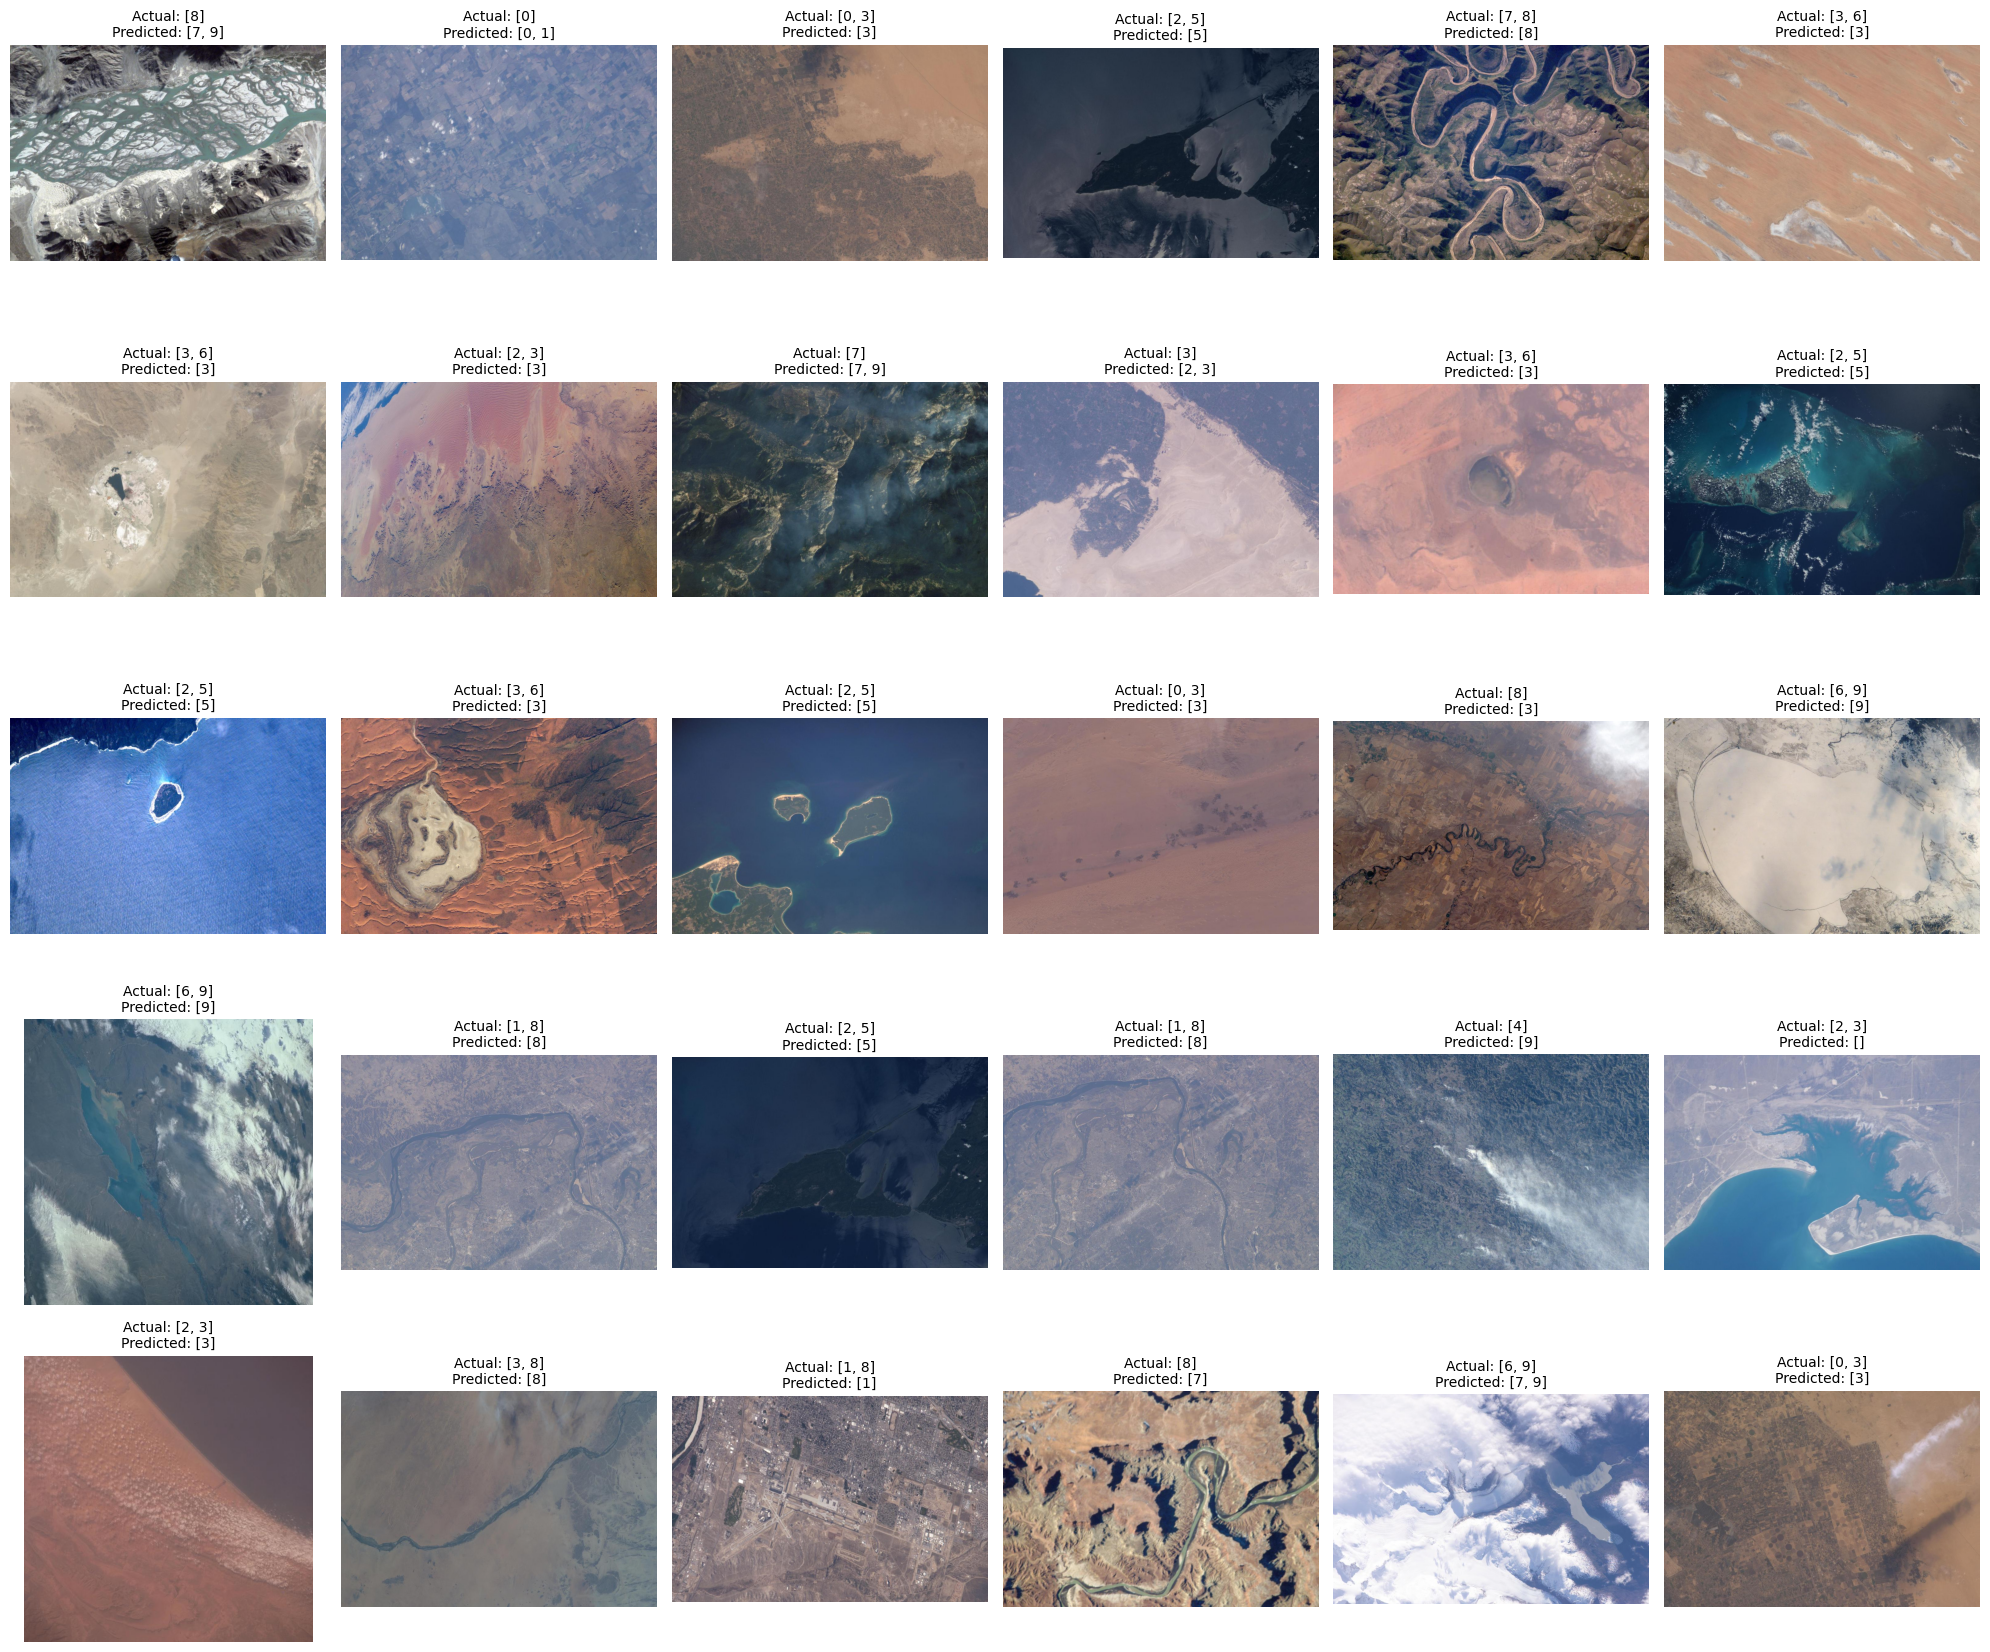

In [29]:
# Now plot the incorrect images
def plot_incorrect_predictions(incorrect_preds, label_names=None, max_images=30):
    """
    Plot images with incorrect predictions
    
    Parameters:
    - incorrect_preds: List of dicts with keys 'image_path', 'actual', 'predicted'
    - label_names: List of label names corresponding to positions in one-hot vector
    - max_images: Maximum number of images to plot
    """
    # Limit number of images to display
    num_to_show = min(max_images, len(incorrect_preds))
    
    # Calculate grid size
    grid_size = int(np.ceil(np.sqrt(num_to_show)))
    
    plt.figure(figsize=(20, 20))
    
    for i in range(num_to_show):
        plt.subplot(grid_size, grid_size, i + 1)
        
        # Load and display image
        img_path = os.path.join(Config.images_path, incorrect_preds[i]['image_path'])
        img = plt.imread(img_path)
        plt.imshow(img)
        
        # Format actual and predicted labels
        actual = incorrect_preds[i]['actual']
        predicted = incorrect_preds[i]['predicted']
        
        if label_names:
            # Convert one-hot encoded vectors to label names
            actual_labels_text = ', '.join([label_names[j] for j, val in enumerate(actual) if val == 1])
            pred_labels_text = ', '.join([label_names[j] for j, val in enumerate(predicted) if val == 1])
            if not actual_labels_text:
                actual_labels_text = "None"
            if not pred_labels_text:
                pred_labels_text = "None"
        else:
            # Display raw vectors
            actual_indices = [j for j, val in enumerate(actual) if val == 1]
            pred_indices = [j for j, val in enumerate(predicted) if val == 1]
            actual_labels_text = f"[{', '.join(map(str, actual_indices))}]"
            pred_labels_text = f"[{', '.join(map(str, pred_indices))}]"
        
        # set title
        plt.title(f"Actual: {actual_labels_text}\nPredicted: {pred_labels_text}", fontsize=10)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Plot incorrect predictions
plot_incorrect_predictions(incorrect_predictions)

## Confusion Matrix

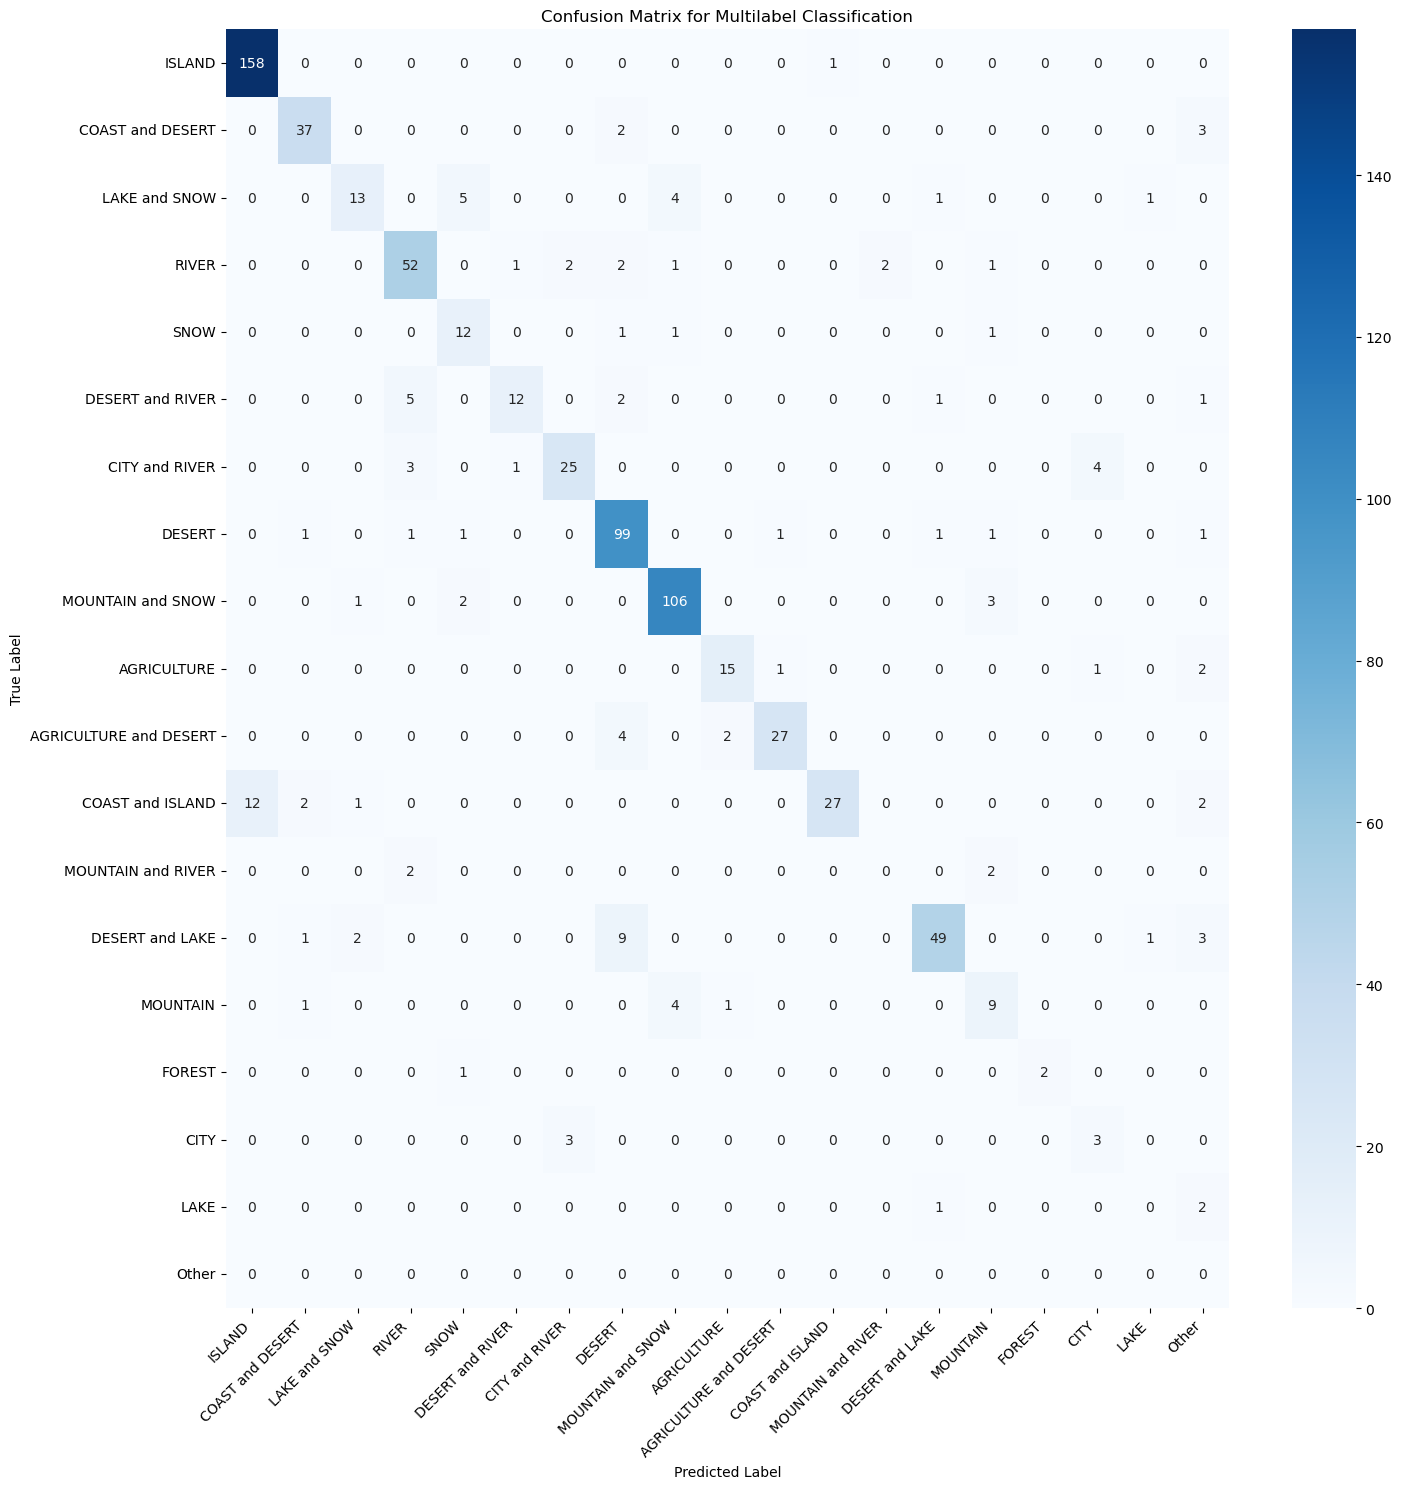

In [30]:
def create_multilabel_confusion_matrix(y_true_arrays, y_pred_arrays, test_data_raw):
    valid_combinations = []
    valid_label_names = {}
    
    # unique label vectors from test data
    for _, row in test_data_raw.drop_duplicates(subset=['Label Vector']).iterrows():
        label_vector = np.array(row['Label Vector'].strip('[]').split(', '), dtype=int)
        if isinstance(label_vector, np.ndarray):
            vector_tuple = tuple(label_vector.flatten())
        else:
            for arr in label_vector:
                if isinstance(arr, np.ndarray):
                    vector_tuple = tuple(arr.flatten())
                    break
                    
        valid_combinations.append(vector_tuple)
        valid_label_names[vector_tuple] = row['Label String']
    
    # add "Other" category
    other_idx = len(valid_combinations)
    
    # convert true and predicted arrays to tuples
    y_true_tuples = []
    y_pred_tuples = []
    
    for array in y_true_arrays:
        for row in array:
            y_true_tuples.append(tuple(row))
            
    for array in y_pred_arrays:
        for row in array:
            y_pred_tuples.append(tuple(row))
    
    # Map each tuple to the index of its class or to "Other"
    def get_class_index(tup):
        if tup in valid_combinations:
            return valid_combinations.index(tup)
        else:
            return other_idx
    
    # convert tuples to class indices
    y_true_indices = [get_class_index(t) for t in y_true_tuples]
    y_pred_indices = [get_class_index(t) for t in y_pred_tuples]
    
    # create labels for the confusion matrix
    labels = [valid_label_names[combo] for combo in valid_combinations] + ["Other"]
    
    # create the confusion matrix
    cm = confusion_matrix(y_true_indices, y_pred_indices, 
                          labels=range(len(valid_combinations) + 1))
    
    # create a DataFrame for better visualization
    cm_df = pd.DataFrame(cm, index=labels, columns=labels)
    
    return cm, cm_df, labels

def plot_confusion_matrix(cm_df, labels, figsize=(15, 15)):
    # create the plot
    plt.figure(figsize=figsize)
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix for Multilabel Classification')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    # rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    
    plt.tight_layout()
    return plt.gcf()

cm, cm_df, labels = create_multilabel_confusion_matrix(
    actual_labels, predicted_labels, val_data_raw)
fig = plot_confusion_matrix(cm_df, labels)
plt.show()

# Grading/Submission Guidelines

## Submissions
Please email your submissions to hamzah.abdulrazzaq@lmco.com. All these items must be complete in order for your submission to be considered for evaluation. 
> 1. Email title set to *yourteamname_submission* 
> 2. The python notebook with all your code (.ipynb) 
> 3. Your model checkpoint (.pt) file
> 4. F1 Score copied in with all the digits

**NOTE**: If your email submission is blocked, please try resending the email with a .allow extension added to the file or email title.

Feel free to check out these resources to learn more about evaluation metrics used in Data Science: 
> - https://towardsdatascience.com/how-to-evaluate-machine-learning-model-performance-in-python-135b4ae27f7e 
> - F1 Score: https://towardsdatascience.com/how-to-evaluate-machine-learning-model-performance-in-python-135b4ae27f7e

## Evaluation Process
> - The submission deadline is on Sunday (9/7) 12PM.
> - Presentations will take place on Sunday (9/7) 2PM for the top 3 teams highest performing solutions. Teams will provide a walkthrough of their code. A winner shall be announced thereafter.